In [132]:
import numpy as np
import skimage as sk
import skimage.io as skio
import matplotlib.pyplot as plt
from skimage import transform, exposure, filters
import os
import cv2
from PIL import Image 



In [271]:
def load_image(image_path): 
      return skio.imread(image_path)

def split_channels(image):
    height = image.shape[0] // 3
    return [
        image[:height, :],      # Blue (top)
        image[height:2*height, :],  # Green (middle) 
        image[2*height:3*height, :]      # Red (bottom)
        #height = 1025 then [682:1025] -> 343 pixel hence canot be [2*height:,:]
    ]

In [ ]:
#filter functions 
def L2(img1, img2): 
    return np.sum((img1 - img2)**2)

def L1(img1, img2): 
    return np.sum(np.abs(img1 - img2))

# def NCC(img1, img2): 
#     #Normalized Cross-Correlation
#     img1_normalized = (img1 - np.mean(img1))/np.std(img1)
#     img2_normalized = (img2 - np.mean(img2))/np.std(img2)
#     #correlation is 1/n sum of (yi - m)/std_y * (xi - m)/std_x for every x,y pair
#     return -np.sum(img1_normalized * img2_normalized)


def extract_edge_features(image):
    # Compute gradients  -- using a high pass filter 
    dx = filters.sobel_h(image)
    dy = filters.sobel_v(image)
    epsilon = 1e-8
    gradient_magnitude = np.sqrt(dx**2 + dy**2 + epsilon)
    return gradient_magnitude
    

def edge_ssd(img1, img2):
    edges1 = extract_edge_features(img1)
    edges2 = extract_edge_features(img2)
    
    return np.sum((edges1 - edges2) ** 2)

In [ ]:
#extensive search method 
def find_best_offset(channel1, reference, filter_func, search_range=15, offset_guess=(0, 0)):
    best_score = np.inf
    best_offset = offset_guess

    crop_margin = search_range + 5


    #create a search window centered around the guess value
    dx0, dy0 = offset_guess
    for dx in range(dx0 - search_range, dx0 + search_range + 1):
        for dy in range(dy0 - search_range, dy0 + search_range + 1):


            #the max displacement from the guess value is 15 (abs value), hence at most 15 line will be effected by the roll and need cropping
            shifted = np.roll(channel1, (dx, dy), axis=(0, 1))

            ref_cropped = reference[crop_margin:-crop_margin, crop_margin:-crop_margin]
            shifted_cropped = shifted[crop_margin:-crop_margin, crop_margin:-crop_margin]

            if ref_cropped.shape == shifted_cropped.shape:
                score = filter_func(ref_cropped, shifted_cropped)
                if score < best_score:
                    best_score = score
                    best_offset = (dx, dy)

    return best_offset


In [370]:
#pyramid method
def find_best_offset_pyramid(channel1, reference, filter_func, search_range=15, levels=3):
    if levels == 0 or min(channel1.shape) < 100: #prevent unneccesary downsampling although should not happen if the level is calcualted correctly
        return find_best_offset(channel1, reference, filter_func, search_range) 
    
    # normalization
    channel1 = (channel1 - np.mean(channel1)) / (np.std(channel1) + 1e-8)
    reference = (reference - np.mean(reference)) / (np.std(reference) + 1e-8)
    
    # pyramid search range 
    level_search_range = max(3, search_range // 2)
    
    kernel = (3, 3)
    blurred1 = cv2.GaussianBlur(channel1, kernel, 0)
    blurred_ref = cv2.GaussianBlur(reference, kernel, 0)
    small1 = blurred1[::2, ::2]  # Downsample by 2
    small_ref = blurred_ref[::2, ::2]
    
    # pass downsampled images to get guess offsets
    dx_level_offset, dy_level_offset = find_best_offset_pyramid(
        small1, small_ref, filter_func, level_search_range, levels-1
    )
    
    dx_guess = dx_level_offset * 2
    dy_guess = dy_level_offset * 2
    
    # Smaller window at finest level
    if levels == 1:  
        range_offset = 2  
    else:
        range_offset = 3  
    
    best_score = np.inf 
    best_offset = (dx_guess, dy_guess)
    
    #crop_margin = max(15, search_range) 
    crop_margin = range_offset + 5

    ref_cropped = reference[crop_margin:-crop_margin, crop_margin:-crop_margin]
    
    offsets_to_try = []
    for dx in range(-range_offset, range_offset + 1):
        for dy in range(-range_offset, range_offset + 1):
            offsets_to_try.append((dx, dy))
    
    # sort by distance from center for early termination
    offsets_to_try.sort(key=lambda x: abs(x[0]) + abs(x[1]))
    
    for dx_off, dy_off in offsets_to_try:
        dx = dx_guess + dx_off
        dy = dy_guess + dy_off
        
        shifted = np.roll(channel1, (dx, dy), axis=(0, 1))
        shifted_cropped = shifted[crop_margin:-crop_margin, crop_margin:-crop_margin]
        
        score = filter_func(ref_cropped, shifted_cropped)
        
        if score < best_score:
            best_score = score
            best_offset = (dx, dy)
            
            if best_score < 1e-6:  
                break
    
    return best_offset

In [371]:
#not used 
def find_best_offset_pyramid_broken(channel1, reference, filter_func, search_range = 15, levels=3):
    if levels == 0 or min(channel1.shape) < 100: 
        return find_best_offset(channel1, reference, filter_func, search_range) 

                       
    channel1 = (channel1 - np.mean(channel1)) / (np.std(channel1) + 1e-8)
    reference = (reference - np.mean(reference)) / (np.std(reference) + 1e-8)


    
    level_search_range = max(3, search_range // (2))

    kernel = (5, 5)
    blurred1 = cv2.GaussianBlur(channel1, kernel, 0)
    blurred_ref = cv2.GaussianBlur(reference, kernel, 0)
    small1 = blurred1[::2, ::2]  
    small_ref = blurred_ref[::2, ::2]

    dx_level_offset, dy_level_offset = find_best_offset_pyramid(small1, small_ref, filter_func, level_search_range, levels-1)

    dx_guess = dx_level_offset * 2
    dy_guess = dy_level_offset * 2

    #the range_offset here is too big, hence making unneccesary search instead of refining, takes like 3 min 
    range_offset = max(5, level_search_range * 2)
    best_score = np.inf 
    best_offset = (dx_guess, dy_guess)

    crop_margin = max(10, search_range)

    for dx in range(dx_guess - range_offset, dx_guess + range_offset+1): 
        for dy in range(dy_guess - range_offset, dy_guess + range_offset+1): 
             
            shifted = np.roll(channel1, (dx, dy), axis=(0, 1))

            ref_cropped = reference[crop_margin:-crop_margin, crop_margin:-crop_margin]
            shifted_cropped = shifted[crop_margin:-crop_margin, crop_margin:-crop_margin]

            score = filter_func(ref_cropped, shifted_cropped)
                
            if score < best_score: 
                best_score = score
                best_offset = (dx, dy)

    return best_offset

In [372]:
def align_channels(b_channel, g_channel, r_channel, filter_func, search_range=15):
   
    original_dtype = b_channel.dtype

    b_channel = b_channel.astype(np.float32)
    g_channel = g_channel.astype(np.float32) 
    r_channel = r_channel.astype(np.float32)
    
    #calculate levels
    min_size = min(b_channel.shape)
    levels = max(3, int(np.log2(min_size / 100)) + 1)
    print(min_size, levels)
    
    offset_g = find_best_offset_pyramid(g_channel, b_channel, filter_func, search_range, levels)
    offset_r = find_best_offset_pyramid(r_channel, b_channel, filter_func, search_range, levels)

    # offset_g = find_best_offset(g_channel, b_channel, filter_func, search_range)
    # offset_r = find_best_offset(r_channel, b_channel, filter_func, search_range)

    aligned_g = np.roll(g_channel, offset_g, axis=(0, 1))
    aligned_r = np.roll(r_channel, offset_r, axis=(0, 1))
    print(f"Green offset: {offset_g}, Red offset: {offset_r}")

    #cropping, crop the greater offset of the two
    safe_dx = max(abs(offset_g[0]), abs(offset_r[0]), 0)
    safe_dy = max(abs(offset_g[1]), abs(offset_r[1]), 0)
    
    # calculate safe cropping boundaries, ensure 1 row/column remain, for debugging 
    # safe_dx = min(max_dx, b_channel.shape[0] // 2 - 1) 
    # safe_dy = min(max_dy, b_channel.shape[1] // 2 - 1)  
    
    if safe_dx > 0 and safe_dy > 0:
        cropped_b = b_channel[safe_dx:-safe_dx, safe_dy:-safe_dy]
        cropped_g = aligned_g[safe_dx:-safe_dx, safe_dy:-safe_dy]
        cropped_r = aligned_r[safe_dx:-safe_dx, safe_dy:-safe_dy]
    else:
        # no cropping needed or safe
        cropped_b = b_channel
        cropped_g = aligned_g
        cropped_r = aligned_r
    
   
    aligned_image = np.stack([cropped_r, cropped_g, cropped_b], axis=-1)

    if original_dtype == np.uint16:
        aligned_image = aligned_image.astype(np.uint16)
    else:
        aligned_image = aligned_image.astype(np.uint8)

    return aligned_image, offset_g, offset_r

Image shape: (9627, 3702), dtype: uint16
Testing L2 (SSD) alignment:
3209 6
Green offset: (27, 8), Red offset: (109, -189)


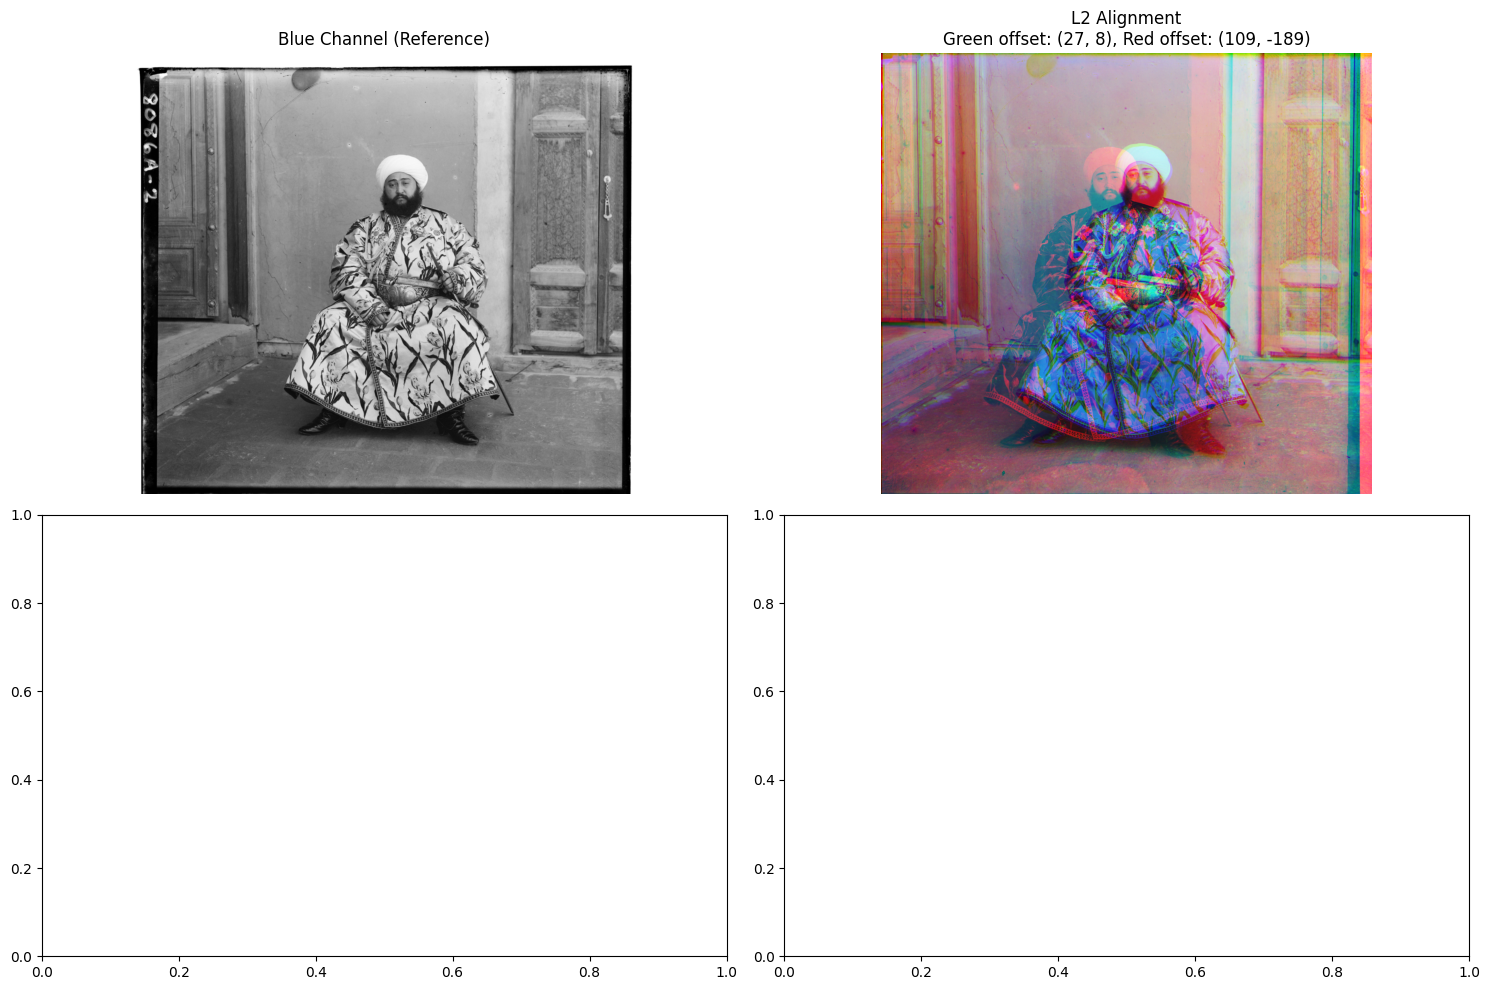

In [373]:
import time

def to_display(image):
    if image.dtype == np.uint16:
        result = image.astype(np.float32) / 65535.0  
    elif image.dtype == np.uint8:
        result = image.astype(np.float32) / 255.0    
    else:
        result = image.copy().astype(np.float32)
    
    # Handle NaN values by replacing them with 0 for debug
    # if np.any(np.isnan(result)):
    #     result = np.nan_to_num(result, nan=0.0)

    # if np.any(np.isinf(result)):
    #     result = np.nan_to_num(result, posinf=1.0, neginf=0.0)
    
    # result = np.clip(result, 0, 1)
    
    return result


def uint16_to_uint8(image_16bit):
    """cnvert 16-bit image to 8-bit for JPEG """
    if image_16bit.dtype == np.uint16:
        image_8bit = (image_16bit / 65535 * 255).astype(np.uint8)
        return image_8bit
    return image_16bit

def get_image_name_from_path(image_path):
    base_name = os.path.basename(image_path)  
    image_name = os.path.splitext(base_name)[0]  
    return image_name


def test_alignment_methods(image_path):
    image = skio.imread(image_path)
    b, g, r = split_channels(image)
    print(f"Image shape: {image.shape}, dtype: {image.dtype}")
    
    out_dir = "../web/photos"
    os.makedirs(out_dir, exist_ok=True)
    

    print("Testing L2 (SSD) alignment:")
    aligned_l2, l2_offset_g, l2_offset_r= align_channels(b, g, r, L2, 15)

    
    # print("Testing NCC alignment:")
    # aligned_ncc, ncc_offset_g, ncc_offset_r= align_channels(b, g, r, NCC, 15)

    
    # print("Testing Edge SSD alignment:")
    # aligned_edge, edge_offset_g, edge_offset_r = align_channels(b, g, r, edge_ssd, 15)

    # print("Testing L1 alignment:")
    # aligned_l1, l1_offset_g, l1_offset_r= align_channels(b, g, r, L1, 15)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    axes[0, 0].imshow(b, cmap='gray')
    axes[0, 0].set_title('Blue Channel (Reference)')
    axes[0, 0].axis('off')


    # axes[1, 0].imshow(to_display(aligned_l1))
    # axes[1, 0].set_title(f'L1 Alignment\nGreen offset: {l1_offset_g}, Red offset: {l1_offset_r}')
    # axes[1, 0].axis('off')
    
    # L2 Alignment
    axes[0, 1].imshow(to_display(aligned_l2))
    axes[0, 1].set_title(f'L2 Alignment\nGreen offset: {l2_offset_g}, Red offset: {l2_offset_r}')
    axes[0, 1].axis('off')
    
    # NCC Alignment
    # print(f"NCC aligned image dtype: {aligned_ncc.dtype}")
    # print(f"NCC aligned image contains NaN: {np.any(np.isnan(aligned_ncc))}")
    # print(f"NCC aligned image contains Inf: {np.any(np.isinf(aligned_ncc))}")
    # print(f"NCC aligned image range: [{np.min(aligned_ncc)}, {np.max(aligned_ncc)}]")
    # axes[1, 0].imshow(to_display(aligned_ncc))
    # axes[1, 0].set_title(f'NCC Alignment\nGreen offset: {ncc_offset_g}, Red offset: {ncc_offset_r}')
    # axes[1, 0].axis('off')
    
    # # Edge SSD Alignment
    # axes[1, 1].imshow(to_display(aligned_edge))
    # axes[1, 1].set_title(f'Edge SSD Alignment\nGreen offset: {edge_offset_g}, Red offset: {edge_offset_r}')
    # axes[1, 1].axis('off')
    
    image_name = get_image_name_from_path(image_path)
    timestamp = int(time.time())
    


    out_dir = "../web/photos"
    os.makedirs(out_dir, exist_ok=True)
    #skio.imsave(os.path.join(out_dir, f"{image_name}_aligned_L1_{timestamp}.jpg"), uint16_to_uint8(aligned_l1))
    skio.imsave(os.path.join(out_dir, f"{image_name}_aligned_L2_{timestamp}.jpg"), uint16_to_uint8(aligned_l2))
    #skio.imsave(os.path.join(out_dir, f"{image_name}_aligned_NCC_{timestamp}.jpg"), uint16_to_uint8(aligned_ncc))
    #skio.imsave(os.path.join(out_dir, f"{image_name}_aligned_EDGE_{timestamp}.jpg"), uint16_to_uint8(aligned_edge))
   
    plt.tight_layout()
    comparison_fig_path = os.path.join(out_dir, f"alignment_comparison_{int(time.time())}.jpg")

    plt.savefig(comparison_fig_path, dpi=300, bbox_inches='tight', pad_inches=0.1)

    plt.show()
    
    return aligned_l2, aligned_ncc, aligned_edge

# Run the test
aligned_l2, aligned_ncc, aligned_edge = test_alignment_methods('../data/emir.tif')